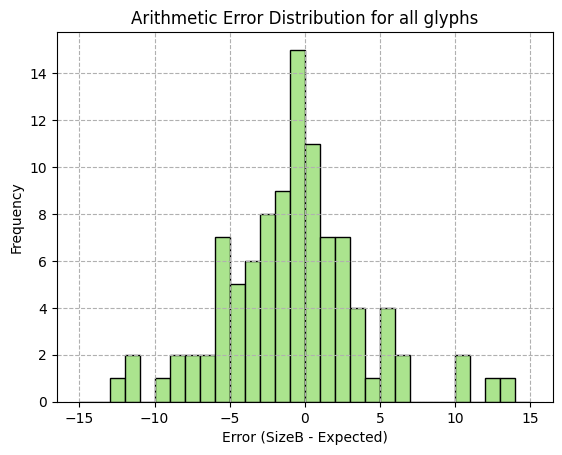

In [69]:
import numpy as np
import matplotlib.pyplot as plt

input_file = "data_sets/all_results.csv"

def open_data_file(input_file):
    with open(input_file, "r") as f:
        lines = f.readlines()
        data_lines = lines[1:]  # csv header
    return data_lines

data_lines = open_data_file(input_file)

# pokus aritmeticka chyba
def compute_arithmetic_error():    
    ar_diffs_all = []
    ar_expected_all = []

    ar_diffs_line = []
    ar_diffs_circle = []
    ar_diffs_square = []
    ar_diffs_star = []
    ar_diffs_polygon = []

    size_diff_all = []

    for i in range(len(data_lines)):
        data_lines[i] = data_lines[i].strip().split(",")
        data_lines[i][2] = int(data_lines[i][2])  
        data_lines[i][3] = int(data_lines[i][3])
        data_lines[i][4] = int(data_lines[i][4])

        sizeA = data_lines[i][2]
        sizeB = data_lines[i][3]
        sizeC = data_lines[i][4]

        size_diff = abs(sizeA - sizeC)

        ar_expected = (sizeA + sizeC) / 2
        diff = sizeB - ar_expected

        ar_expected_all.append(ar_expected)
        ar_diffs_all.append(diff)
        size_diff_all.append(size_diff)

        if data_lines[i][1] == "line":
            ar_diffs_line.append(diff)
        elif data_lines[i][1] == "circle":
            ar_diffs_circle.append(diff)
        elif data_lines[i][1] == "square":
            ar_diffs_square.append(diff)
        elif data_lines[i][1] == "star":
            ar_diffs_star.append(diff)
        elif data_lines[i][1] == "polygon":
            ar_diffs_polygon.append(diff)

        #print(f"SizeA: {sizeA}, SizeB: {sizeB}, SizeC: {sizeC}, Expected: {ar_expected}, Diff: {diff}, Size_diff: {size_diff}")

    return (size_diff_all, ar_expected_all, ar_diffs_all, ar_diffs_line, ar_diffs_circle, ar_diffs_square, ar_diffs_star, ar_diffs_polygon)

size_diff_all, ar_expected_all, ar_diffs_all, ar_diffs_line, ar_diffs_circle, ar_diffs_square, ar_diffs_star, ar_diffs_polygon = compute_arithmetic_error()

plt.hist(ar_diffs_all, bins=np.arange(-15, 16, 1), edgecolor='black', color=np.random.rand(3))

plt.xlabel("Error (SizeB - Expected)")
plt.ylabel("Frequency")
plt.title("Arithmetic Error Distribution for all glyphs")
plt.grid(linestyle='--')

plt.show()


In [ ]:
glyph_diffs = {
    "line": ar_diffs_line,
    "square": ar_diffs_square,
    "circle": ar_diffs_circle,
    "star": ar_diffs_star,
    "polygon": ar_diffs_polygon
}

for glyph, diffs in glyph_diffs.items():
    plt.hist(diffs, bins=np.arange(-15, 16, 1), edgecolor='black', color=np.random.rand(3))
    plt.xlabel("Error (SizeB - Expected)")
    plt.ylabel("Frequency")
    plt.ylim(0, 5)
    plt.title(f"Error Distribution for {glyph.capitalize()}")
    plt.grid(linestyle='--')
    plt.show()

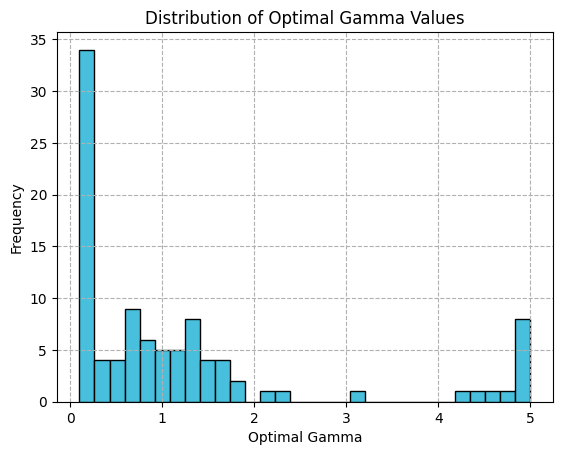

Average gamma: 1.21639 with median: 0.70882
Avg error: 0.00163 with median: 0.00020


In [ ]:
# gamma correction
# jednoparametrovy model
# P = S^gamma
# |S2^gamma - Sx^gamma| = |Sx^gamma - S1^gamma|
# chci aby na skale vnimani (osa y) byla chyba co nejmensi, aby platilo, ze B lezi mezi A a C
# minimalizuji chybu diff = B^gamma - ((A^gamma + C^gamma) / 2)
# muzu si vyzkouset ruzne hodnoty gamma a najit tu, ktera minimalizuje chybu    

def my_gamma(A, B, C):
    a = np.clip(A / 100, 0, 1)
    b = np.clip(B / 100, 0, 1)
    c = np.clip(C / 100, 0, 1)

    gammas = np.linspace(0.1, 5.0, 500)
    errors = []
    errors = np.abs(b**gammas - (a**gammas + c**gammas) / 2)
    i = np.argmin(errors)
    
    return gammas[i], errors[i]

# pokus, manualni odhad gamma
def process_all_gammas():
    gammas = []
    errors = []
    for i in range(len(data_lines)):
        gamma, error = my_gamma(float(data_lines[i][2]), float(data_lines[i][3]), float(data_lines[i][4]))
        gammas.append(gamma)
        errors.append(error)

    return gammas, errors

gammas, errors = process_all_gammas()

plt.hist(gammas, bins=30, edgecolor='black', color=np.random.rand(3))
plt.xlabel("Optimal Gamma")
plt.ylabel("Frequency")
plt.title("Distribution of Optimal Gamma Values")
plt.grid(linestyle='--')
plt.show()

print(f"Average gamma: {np.mean(gammas):.5f} with median: {np.median(gammas):.5f}")
print(f"Avg error: {np.mean(errors):.5f} with median: {np.median(errors):.5f}")

In [105]:
# metoda nejmensich ctvercu 
from scipy.optimize import least_squares

A = np.array([float(data_lines[i][2]) for i in range(len(data_lines))])
B = np.array([float(data_lines[i][3]) for i in range(len(data_lines))])
C = np.array([float(data_lines[i][4]) for i in range(len(data_lines))])

a = np.clip(A / 100, 0, 1)
b = np.clip(B / 100, 0, 1)  
c = np.clip(C / 100, 0, 1)

def residual_gamma(gamma, a, b, c):
    return b**gamma - (a**gamma + c**gamma) / 2

# vraci B z osy fyzikalni 
def predict_b_gamma(gamma, size_a, size_c):
    b_gamma = (size_a**gamma + size_c**gamma) / 2
    return b_gamma**(1.0/gamma)

def ls_find_gamma(a, b, c):
    result = least_squares(residual_gamma, x0=1.0, bounds=(0.05, 5.0), args=(a, b, c))
    return float(result.x[0])

# Mean Absolute Error (MAE, Stredni absolutni chyba)
# MAE = 1/n * sum abs(y_true - y_predicted)
def MAE(userB, predicted): 
    return np.mean(np.abs(userB - predicted))

glyph_types = set(data_lines[i][1] for i in range (len(data_lines)))

def stats_per_glyph_type(a, b, c):
    rows = []

    all_glyphs_gamma = ls_find_gamma(a, b, c)
    rows.append(("All", len(b), MAE(b, predict_b_gamma(all_glyphs_gamma, a, c)), all_glyphs_gamma))

    for t in glyph_types:
        # seznam indexu pro glyphy daneho typu
        idx = [i for i in range(len(data_lines)) if data_lines[i][1] == t]
        a_t = a[idx]
        b_t = b[idx]
        c_t = c[idx]

        glyphs_t = ls_find_gamma(a_t, b_t, c_t)
        rows.append((t.capitalize(), len(b_t), MAE(b_t, predict_b_gamma(glyphs_t, a_t, c_t)), glyphs_t))

    return rows

def print_table(rows):
    print(f"{'Glyph':<10} {'N':<5} {'MAE':<10} {'Gamma':<10}")
    print("-" * 40)
    for row in rows:
        print(f"{row[0]:<10} {row[1]:<5} {row[2]:<10.4f} {row[3]:<10.5f}")

rows = stats_per_glyph_type(a, b, c)
print_table(rows)


Glyph      N     MAE        Gamma     
----------------------------------------
All        100   0.0352     0.85167   
Circle     20    0.0341     0.71189   
Polygon    20    0.0326     1.42464   
Line       20    0.0336     0.94397   
Star       20    0.0379     0.94583   
Square     20    0.0208     0.66424   


In [112]:
# plot funkci pro gamma
